In [1]:
import os
import json
import pickle
import sys
sys.path.insert(0, '../')
from trainRNNbrain.datasaver.DataSaver import DataSaver
from trainRNNbrain.analyzers.DynamicSystemAnalyzer import *
from trainRNNbrain.analyzers.PerformanceAnalyzer import *
from trainRNNbrain.rnns.RNN_numpy import RNN_numpy
from trainRNNbrain.rnns.RNN_torch import RNN_torch
from trainRNNbrain.utils import get_project_root, numpify, orthonormalize
from trainRNNbrain.trainer.Trainer import Trainer
from trainRNNbrain.tasks.TaskMemoryAntiAngle import *
from matplotlib import pyplot as plt
import torch
import time
from sklearn.decomposition import PCA

python: can't open file '/Users/tolmach/Documents/GitHub/trainRNNbrain/jupyter/../../style/style_setup.py': [Errno 2] No such file or directory


In [2]:
import typing as T
import os
import matplotlib.colors as mcolors
import matplotlib.font_manager as mfonts
from trainRNNbrain.utils import get_project_root
from matplotlib import pyplot as plt

def setup_fonts(fontpaths, verbose: bool = False, **kwargs):
    for font in sorted(mfonts.findSystemFonts(fontpaths=fontpaths, **kwargs)):
        mfonts.fontManager.addfont(font)
        if verbose: print(f'font:\t{os.path.basename(font)}')


def setup_colors(themepaths, verbose: bool = False):
    for themepath in themepaths:
        with open(themepath, 'rt') as f:
            lines = f.readlines()
            for line in lines:
                line = line.strip()
                if line.startswith('#'): continue
                names, value = line.split(':')
                value = value.strip()
                for name in names.split(','):
                    name = name.strip()
                    mcolors._colors_full_map[name] = value  # type: ignore
                    if verbose: print(f'color:\t{name:16s} {value:}')

setup_fonts([os.path.join(get_project_root(), "style", "assets", "fonts")], verbose=False)
setup_colors([os.path.join(get_project_root(), "style", "assets", "styles", "scientific.txt")], verbose=False)
plt.style.use([os.path.join(get_project_root(), 'style', 'assets', 'styles', 'scientific.mplstyle'), {'figure.dpi': 144}])

In [3]:
# defining RNN:
N = 100
activation_name = 'relu'
activation_slope = 1.0
dt = 1
tau = 10
exc_to_inh_ratio = 4
constrained = True # whether to impose Dale constraint and positivity of inputs and outputs
connectivity_density_rec = 1.0 # no sparsity here
spectral_rad = 1.2 
sigma_inp = 0.05
sigma_rec = 0.05
seed = 0

n_angle_encoding_variables = 3
input_size = n_angle_encoding_variables + 2 # n_angle_encoding_variables inputs encoding the angle, 1 bias, 1 Go Cue
output_size = n_angle_encoding_variables 

In this task there the incoming angle is encoded by 3 numbers:
the whole circle representing 360 degrees is divided into 3 arks, by three equidistant points.
- the 0 degree angle is represented by the full activity of the first input channel 
- the 60 degree angle is represented by the equal mixture of activity of the first and the second input channel
- the 120 degree angle is represented by the pure activity of the second input channel.
- the 150 degree angle is represented by the equal mixture activity of the second and the third input channel
and so on.


'A' degrees angle is encoded as:

num_angle_encoding_inps = 3

arc_length = 2 * np.pi / num_angle_encoding_inps % 120 in this case

ind_channel = int(np.floor(A / arc_length)) 

v = A % arc

input_stream[ind_channel % num_angle_encoding_inps, stim_on: stim_off] = (1 - v/arc)

input_stream[(ind_channel + 1) % num_angle_encoding_inps, stim_on: stim_off] = v/arc

input_stream[(ind_channel + 2) % num_angle_encoding_inps, stim_on: stim_off] = 0

In [5]:
# Task:
T = 100
n_steps = int(np.ceil(T/dt))
stim_on = 10
stim_off = 20
random_window = 10
recall_on = 50
recall_off = n_steps

In [6]:
# Trainer:
lambda_orth = 0.3
lambda_r = 0.0
train_mask = np.arange(n_steps)
max_iter = 2000
tol = 1e-10
lr = 0.02
weight_decay = 1e-6
same_batch = False # generate new bath every new iteration

In [7]:
# creating instances:
rnn_torch = RNN_torch(N=N,
                      activation_name=activation_name,
                      activation_slope=activation_slope,
                      dt=dt,
                      tau=tau,
                      input_size=input_size,
                      output_size=output_size,
                      constrained=constrained,
                      exc_to_inh_ratio=exc_to_inh_ratio,
                      sigma_inp=sigma_inp,
                      sigma_rec=sigma_rec,
                      connectivity_density_rec=connectivity_density_rec,
                      spectral_rad=spectral_rad,
                      seed=seed)

#task
task = TaskMemoryAntiAngle(n_steps=n_steps,
                           n_inputs=input_size,
                           n_outputs=output_size, 
                           stim_on=stim_on, 
                           stim_off=stim_off,
                           random_window=random_window,
                           recall_on=recall_on,
                           recall_off=recall_off)

criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(rnn_torch.parameters(),
                             lr=lr,
                             weight_decay=weight_decay)
#trainer
trainer = Trainer(RNN=rnn_torch, Task=task,
                  max_iter=max_iter, tol=tol,
                  optimizer=optimizer, criterion=criterion,
                  lambda_orth=lambda_orth, lambda_r=lambda_r)
datasaver = None

Using cpu for RNN!


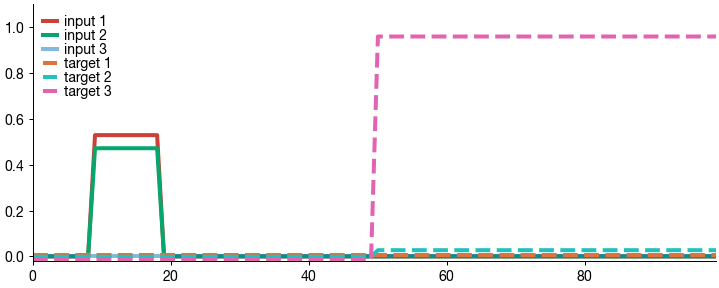

In [8]:
inputs, targets, conditions = task.get_batch()
ind = 11

fig = plt.figure(figsize = (5, 2))
plt.plot(inputs[0, :, ind], color = 'red', linewidth=2, label = 'input 1')
plt.plot(inputs[1, :, ind], color = 'green',  linewidth=2, label = 'input 2')
plt.plot(inputs[2, :, ind], color = 'blue',  linewidth=2, alpha = 0.5, label = 'input 3')

plt.plot(targets[0, :, ind] + 0.01 * np.random.randn(), color = 'orange',  linewidth=2, linestyle = '--', label = 'target 1')
plt.plot(targets[1, :, ind] + 0.01 * np.random.randn(), color = 'cyan',  linewidth=2, linestyle = '--', label = 'target 2')
plt.plot(targets[2, :, ind] + 0.01 * np.random.randn(), color = 'magenta',  linewidth=2, linestyle = '--', label = 'target 3')
plt.ylim([-0.02, 1.1])
plt.legend()
plt.show()

In [ ]:
# training RNNs
trained_rnn, train_losses, val_losses, best_rnn_params = trainer.run_training(train_mask=train_mask, same_batch=same_batch, shuffle=False)

#save the parameters
pickle.dump(best_rnn_params, open("./training_MemoryAntiAngle_example/best_rnn_params_MemoryAntiAngle.pkl", "wb+"))

fig_trainloss = plt.figure(figsize=(5, 2))
plt.plot(train_losses, linewidth=2, color='r', label='train loss (log scale)')
plt.plot(val_losses, linewidth=2, color='b', label='valid loss (log scale)')
plt.yscale("log")
plt.grid(True)
plt.xlabel("# epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

iteration 0, train loss: 1.614471, validation loss: 1.432404
iteration 1, train loss: 1.431247, validation loss: 1.406652
iteration 2, train loss: 1.405188, validation loss: 1.343055
iteration 3, train loss: 1.344136, validation loss: 1.235484
iteration 4, train loss: 1.234932, validation loss: 1.105426
iteration 5, train loss: 1.105285, validation loss: 0.993465
iteration 6, train loss: 0.99353, validation loss: 0.891972
iteration 7, train loss: 0.891708, validation loss: 0.792713
iteration 8, train loss: 0.792989, validation loss: 0.703661
iteration 9, train loss: 0.704017, validation loss: 0.628103
iteration 10, train loss: 0.628601, validation loss: 0.566448
iteration 11, train loss: 0.566373, validation loss: 0.515732
iteration 12, train loss: 0.515925, validation loss: 0.474429
iteration 13, train loss: 0.474494, validation loss: 0.437386
iteration 14, train loss: 0.437299, validation loss: 0.403838
iteration 15, train loss: 0.40383, validation loss: 0.374041
iteration 16, train 

In [ ]:
best_rnn_params = pickle.load(open("./training_MemoryAntiAngle_example/best_rnn_params_MemoryAntiAngle.pkl", "rb+"))
best_rnn_params.keys()

In [ ]:
# validate
RNN_valid = RNN_numpy(N=best_rnn_params["N"],
                      dt=best_rnn_params["dt"],
                      tau=best_rnn_params["tau"],
                      W_inp=best_rnn_params["W_inp"],
                      W_rec=best_rnn_params["W_rec"],
                      W_out=best_rnn_params["W_out"],
                      activation_name=activation_name,
                      activation_slope=activation_slope)

In [ ]:
analyzer = PerformanceAnalyzer(RNN_valid)
score_function = lambda x, y: np.mean((x - y) ** 2)
input_batch_valid, target_batch_valid, conditions_valid = task.get_batch()
score = analyzer.get_validation_score(score_function, input_batch_valid, target_batch_valid,
                                      train_mask, sigma_rec=sigma_rec, sigma_inp=sigma_inp)
print(f"MSE validation: {np.round(score, 5)}")

In [ ]:
print(f"Plotting random trials")
inds = np.random.choice(np.arange(input_batch_valid.shape[-1]), 12)
inputs = input_batch_valid[..., inds]
targets = target_batch_valid[..., inds]
conditions = [conditions_valid[ind] for ind in inds]

analyzer.plot_trials(input_batch=inputs,
                     target_batch=targets,
                     mask=train_mask,
                     sigma_rec=sigma_rec,
                     sigma_inp=sigma_inp,
                     conditions=conditions)
plt.show()

In [ ]:
RNN_valid.reset_state()
RNN_valid.clear_history()

dsa = DynamicSystemAnalyzer(RNN_valid, task)
params = {"fun_tol" : 0.05,
          "diff_cutoff":1e-4,
          "sigma_init_guess":15,
          "patience":100,
          "stop_length":100,
          "mode":"approx"}

dsa.get_fixed_points(Input=np.array([0, 0, 0, 0, 0]), **params)
dsa.get_fixed_points(Input=np.array([0, 0, 0, 0, 1]), **params)

pickle.dump(dsa.fp_data, open("./training_MemoryAntiAngle_example/fp_data.pkl", "wb+"))

In [ ]:
all_points = np.vstack([dsa.fp_data[str([0, 0, 0, 0, 0])][type] for type in list(dsa.fp_data[str([0, 0, 0, 0, 1])].keys())])
pca = PCA(n_components=2)
pca.fit(all_points)
P = np.zeros((RNN_valid.N, 3))
P[:, 0] = RNN_valid.W_out[0, :]
P[:, 1:] = pca.components_.T
P = orthonormalize(P)

In [ ]:
fig_fp = dsa.plot_fixed_points(projection='3D', P=P)
plt.xlabel("Output axis", fontsize=16)
plt.show()